In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [22]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v2_figs','shared delay ring')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [23]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_trains = ['fdgo', 'delaygo', 'fdanti']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -0
l2h = -0
l1w = 0
l1h = 0
seed = '0'
# net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# data_folder = 'data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# data_folder = 'data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise'
data_folder = 'data/rnn/multitask/stepnet/no_noise' #8/2/21

m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [24]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    
task_list = hparams['rule_trains']

0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/no_noise/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w0.0_h0.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/no_noise/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w0.0_h0.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


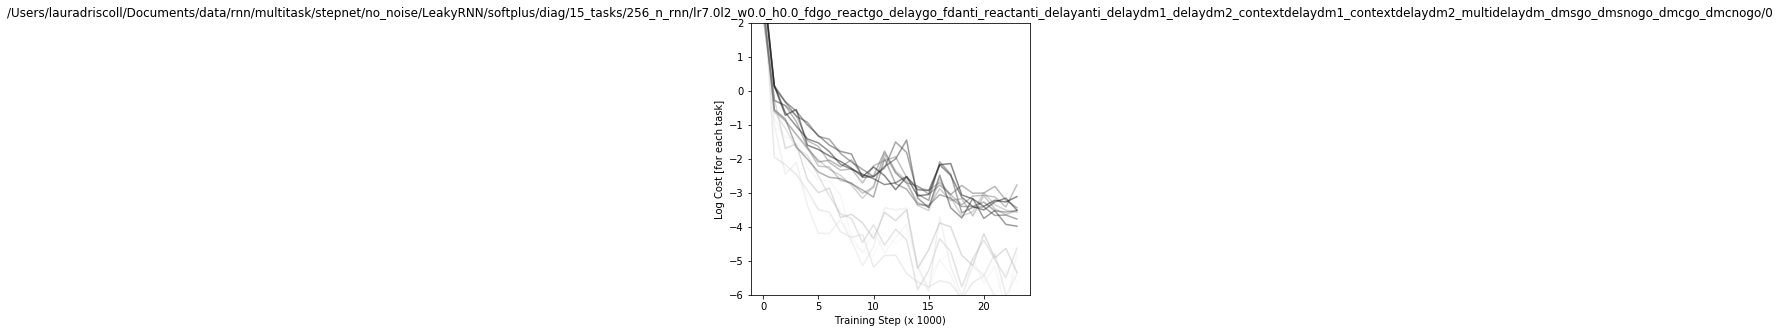

In [25]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

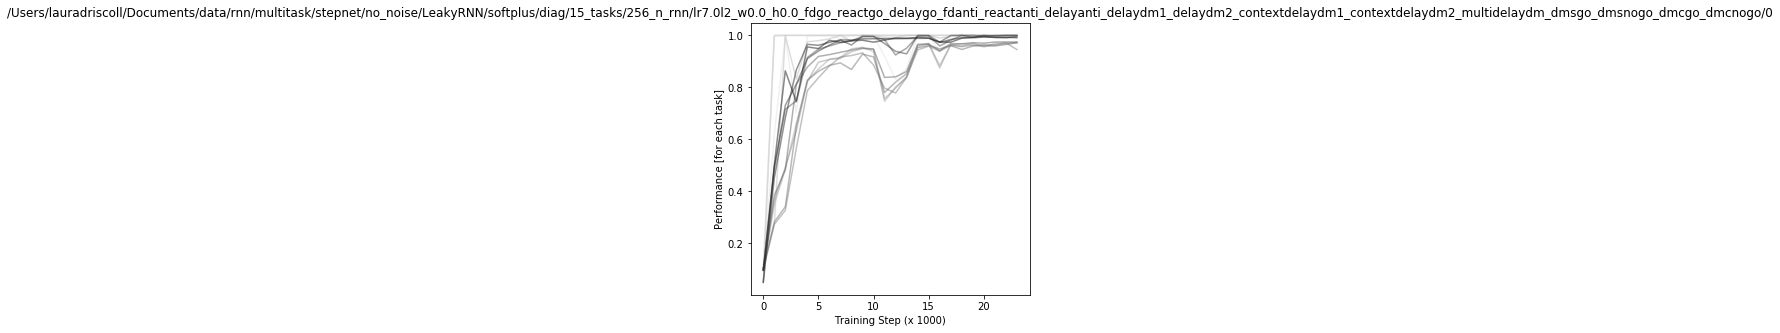

In [26]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Performance [for each task]')
#     plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [7]:
def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

In [8]:
def make_h_combined(m,tasks,epoch,ind = -1,mode = 'random',noise_on = 'False',batch_size = 100):
    
    h_combined = []
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        # model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
#         params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        for rule in tasks:
            
            trial = generate_trials(rule, hparams, mode = mode, noise_on = noise_on, batch_size = batch_size)
            T_inds = get_T_inds(trial,epoch)
            
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            
            X = h_tf[T_inds[ind]-1,:,:]

            #concatenate activity states across tasks
            if h_combined == []:
                h_combined = X
            else:
                h_combined = np.concatenate((h_combined, X), axis=0)

    return h_combined

In [9]:
offset = 0
trial_num = int(offset/4)

rule_set_shared = ['delaygo',
                   'delayanti',
                   'delaydm1',
                   'delaydm2',
                   'contextdelaydm1',
                   'contextdelaydm2',
                   'multidelaydm']

rule_set_other = ['reactgo',
                  'reactanti',
                  'dmsgo',
                  'dmsnogo']

In [ ]:
h_combined = make_h_combined(m,rule_set_other,'go1',ind = 0)

In [ ]:
pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(h_combined)
D_use = pca.components_.T

In [ ]:
w_in, b_in, w_out, b_out = get_model_params(m)
D_out = w_out[:,1:]

In [ ]:
def gen_trials_from_model_dir(model_dir,rule,mode='test',noise_on = True,batch_size = 500):
    model = FixedPoint_Model(model_dir)
    with tf.Session() as sess:
        model.restore()
        # model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
#         params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        trial = generate_trials(rule, hparams, mode=mode, noise_on=noise_on, batch_size =batch_size)
    return trial 

In [ ]:
def make_ax_nice(ax,label):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(label+'1')
    ax.set_ylabel(label+'2')
    
def choose_trials(rule,trial,n_trials_plot = 100, ambiguity_thresh = 1):
    
    mod1 = abs(trial.stim_strength[:,1] - trial.stim_strength[:,0])>ambiguity_thresh
    mod2 = abs(trial.stim_strength[:,3] - trial.stim_strength[:,2])>ambiguity_thresh
    
    if 'dm1' in rule:
        trial_set = np.where(mod1)[0][:n_trials_plot]
    elif 'dm2' in rule:
        trial_set = np.where(mod2)[0][:n_trials_plot]
    elif 'multi' in rule:
        trial_set = np.where(mod1&mod2)[0][:n_trials_plot]
    elif 'dms' in rule:
        trial_set = np.where(trial.y_loc[-1,:]>0)[0][:n_trials_plot]
    else:
        trial_set = range(n_trials_plot)
        
    return trial_set

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
M

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


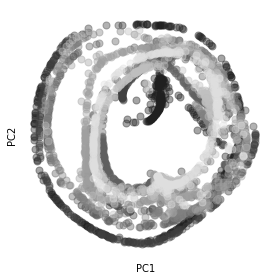

In [15]:
########## X TASK ###########

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')

epoch = 'delay1'
axs = 'PC'
rule_set = rule_set_shared
cmap_grad = plt.get_cmap('gray')

for ri in range(len(rule_set)):
    
    rule = rule_set[ri]
    c_master = cmap_grad((ri+1)/(len(rule_set)+1))
    trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
    
    ax = plt.subplot(111)
    
    filename,_ = get_filename(trial,epoch,trial_num)
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    fp_struct = np.load(f)
    fp_inds = fp_struct['qstar']<.001
    sorted_fps = fp_struct['xstar'][fp_inds,:]
    J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
    eig_decomps = comp_eig_decomp(J_xstar)
    fp_inds = range(len(eig_decomps))

    if axs=='PC':
        fp = np.dot(sorted_fps,D_use)
    else:
        fp = np.dot(sorted_fps,D_out)
    plt.scatter(fp[:,0],fp[:,1],50,c_master,alpha = .4)
    
make_ax_nice(ax,axs)

plotting = 'fixed_pts'
if not os.path.exists(os.path.join(figpath,plotting)):
    os.makedirs(os.path.join(figpath,plotting))
    
rule_set_str = '_'.join(rule_set)
figname = axs+'_'+rule_set_str+'_'+epoch+'_'+str(trial_num)
plt.savefig(os.path.join(figpath,plotting,figname+'.pdf'))
plt.savefig(os.path.join(figpath,plotting,figname+'.png'))
plt.show()

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
M

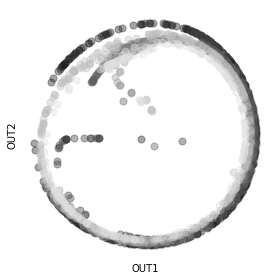

In [16]:
########## X TASK ###########

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')

offset = 0
trial_num = int(offset/4)
rule_set = rule_set_shared
axs='OUT'

epoch = 'go1'
cmap_grad = plt.get_cmap('gray')

for ri in range(len(rule_set)):
    
    rule = rule_set[ri]
    c_master = cmap_grad((ri+1)/(len(rule_set)+1))
    trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
    
    ax = plt.subplot(111)
    
    filename,_ = get_filename(trial,epoch,trial_num)
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    fp_struct = np.load(f)
    fp_inds = fp_struct['qstar']<.001
    sorted_fps = fp_struct['xstar'][fp_inds,:]
    J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
    eig_decomps = comp_eig_decomp(J_xstar)
    fp_inds = range(len(eig_decomps))

    if axs=='PC':
        fp = np.dot(sorted_fps,D_use)
    else:
        fp = np.dot(sorted_fps,D_out)
    plt.scatter(fp[:,0],fp[:,1],50,c_master,alpha = .4)
    
make_ax_nice(ax,axs)

plotting = 'fixed_pts'
if not os.path.exists(os.path.join(figpath,plotting)):
    os.makedirs(os.path.join(figpath,plotting))
    
rule_set_str = '_'.join(rule_set)
figname = axs+'_'+rule_set_str+'_'+epoch+'_'+str(trial_num)
plt.savefig(os.path.join(figpath,plotting,figname+'.pdf'))
plt.savefig(os.path.join(figpath,plotting,figname+'.png'))
plt.show()

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring p

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/

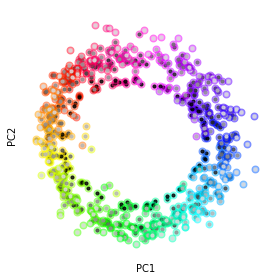

In [20]:
########## X TASK ###########

offset = 0
trial_num = int(offset/4)

cmap_response = plt.get_cmap('hsv')
cmap_task = plt.get_cmap('gray')

ind = 0
epoch = 'go1'
batch_size = 1200
ambiguity_thresh = 1
rule_set = rule_set_shared
axs = 'PC'

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')

for ri in range(len(rule_set)):
    
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,mode='random',noise_on = False, batch_size = batch_size)
    trial_set = choose_trials(rule,trial,ambiguity_thresh = 1)
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = x[:,:,T_inds[ind]-1]
    
    ax = plt.subplot(111)
    if axs=='PC':
        h_set =  np.dot(x_epoch.T,D_use)
    else:
        h_set =  np.dot(x_epoch.T,D_out)
    
    for ti in trial_set:
        plt.scatter(h_set[ti,0],h_set[ti,1],50,cmap_response(trial.y_loc[-1,ti]/(2*np.pi)),alpha = .4)
        plt.scatter(h_set[ti,0],h_set[ti,1],10,cmap_task(ri/len(rule_set)),alpha = .8)
    
#     plt.title(rule)
make_ax_nice(ax,axs)

plotting = 'pts_activity'
if not os.path.exists(os.path.join(figpath,plotting)):
    os.makedirs(os.path.join(figpath,plotting))
    
rule_set_str = '_'.join(rule_set)
figname = axs+'_'+rule_set_str+'_'+epoch+'_'+str(trial_num)
plt.savefig(os.path.join(figpath,plotting,figname+'.pdf'))
plt.savefig(os.path.join(figpath,plotting,figname+'.png'))
plt.show()

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring p

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/

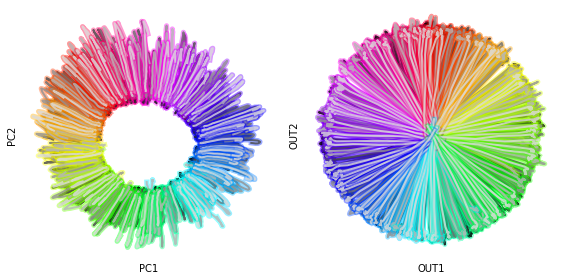

In [18]:
########## X TASK ###########

cmap_response = plt.get_cmap('hsv')
cmap_task = plt.get_cmap('gray')

offset = 0
trial_num = int(offset/4)
ind = 0
epoch = 'go1'
batch_size = 1200
rule_set = rule_set_shared

fig = plt.figure(figsize=(8,4),tight_layout=True,facecolor='white')
for ri in range(len(rule_set)):
    
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,mode='random',noise_on = False, batch_size = batch_size)
    trial_set = choose_trials(rule,trial,ambiguity_thresh = 1)
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    
    for ti in trial_set:
        ax = plt.subplot(121)
        h_set =  np.dot(x[:,ti,T_inds[0]-1:].T,D_use)
        plt.plot(h_set[:,0],h_set[:,1],'-',c = cmap_response(trial.y_loc[-1,ti]/(2*np.pi)),alpha = .4,linewidth = 5)
        plt.plot(h_set[:,0],h_set[:,1],'-',c = cmap_task(ri/len(rule_set)),alpha = .8,linewidth = 2)
        make_ax_nice(ax,'PC')
    
        ax = plt.subplot(122)
        h_set =  np.dot(x[:,ti,T_inds[0]-1:].T,D_out)
        plt.plot(h_set[:,0],h_set[:,1],'-',c = cmap_response(trial.y_loc[-1,ti]/(2*np.pi)),alpha = .4,linewidth = 5)
        plt.plot(h_set[:,0],h_set[:,1],'-',c = cmap_task(ri/len(rule_set)),alpha = .8,linewidth = 2)
        make_ax_nice(ax,'OUT')
        ax.set_xlim([-1.2,1.2])
        ax.set_ylim([-1.2,1.2])
        
#     plt.title(rule)

plotting = 'traj_activity'
if not os.path.exists(os.path.join(figpath,plotting)):
    os.makedirs(os.path.join(figpath,plotting))
    
rule_set_str = '_'.join(rule_set)
figname = 'PC_OUT'+'_'+rule_set_str+'_'+epoch+'_'+str(trial_num)
plt.savefig(os.path.join(figpath,plotting,figname+'.pdf'))
plt.savefig(os.path.join(figpath,plotting,figname+'.png'))
plt.show()

In [ ]:
########## X TASK ###########
rule_set = rule_set_other

cmap_response = plt.get_cmap('hsv')
cmap_task = plt.get_cmap('gray')

offset = 0
trial_num = int(offset/4)
ind = 0
epoch = 'go1'
batch_size = 1200

fig = plt.figure(figsize=(8,4),tight_layout=True,facecolor='white')
for ri in range(len(rule_set)):
    
    
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,mode='random',noise_on = False, batch_size = batch_size)
    trial_set = choose_trials(rule,trial,ambiguity_thresh = 1)
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    
    for ti in trial_set:
        ax = plt.subplot(121)
        h_set =  np.dot(x[:,ti,T_inds[0]-1:].T,D_use)
        plt.plot(h_set[:,0],h_set[:,1],'-',c = cmap_response(trial.y_loc[-1,ti]/(2*np.pi)),alpha = .4,linewidth = 5)
        plt.plot(h_set[:,0],h_set[:,1],'-',c = cmap_task(ri/len(rule_set)),alpha = .8,linewidth = 2)
        make_ax_nice(ax,'PC')
    
        ax = plt.subplot(122)
        h_set =  np.dot(x[:,ti,T_inds[0]-1:].T,D_out)
        plt.plot(h_set[:,0],h_set[:,1],'-',c = cmap_response(trial.y_loc[-1,ti]/(2*np.pi)),alpha = .4,linewidth = 5)
        plt.plot(h_set[:,0],h_set[:,1],'-',c = cmap_task(ri/len(rule_set)),alpha = .8,linewidth = 2)
        make_ax_nice(ax,'OUT')
        ax.set_xlim([-1.2,1.2])
        ax.set_ylim([-1.2,1.2])
        
#     plt.title(rule)

plotting = 'traj_activity'
if not os.path.exists(os.path.join(figpath,plotting)):
    os.makedirs(os.path.join(figpath,plotting))
    
rule_set_str = '_'.join(rule_set)
figname = 'PC_OUT'+'_'+rule_set_str+'_'+epoch+'_'+str(trial_num)
plt.savefig(os.path.join(figpath,plotting,figname+'.pdf'))
plt.savefig(os.path.join(figpath,plotting,figname+'.png'))
plt.show()